MNIST的数据查看

1.相关包导入

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import time

2.读取MNIST数据

In [2]:
(X_train_image,y_train_label),(X_test_image,y_test_label) = tf.keras.datasets.mnist.load_data()

3.打印MNIST数据的尺寸大小

In [3]:
print(len(X_train_image))
print(len(X_test_image))
print(X_train_image.shape)

60000
10000
(60000, 28, 28)


4.定义函数显示数字的图像

In [4]:
def plot_image(image):
    fig=plt.gcf()    #图表生成
    fig.set_size_inches(3,3)  #设置图表大小
    plt.imshow(image,cmap='binary') #以黑白灰度显示图片
    plt.show()    #开始绘图

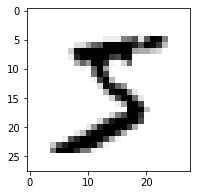

In [5]:
plot_image(X_train_image[0]) #显示一张图片

5.为了更加方便查看图像、标签及预测结果之间对应的关系，我们定义一个函数来显示。

In [6]:
def plot_image_labels_prediction(images,labels,prediction,idx,nums=10):
    fig = plt.gcf() 
    fig.set_size_inches(12,14)  #设置图表大小
    if nums>25: nums=25 #最多显示25张图像
    for i in range(0,nums):
        ax = plt.subplot(5,5,1+i) #子图生成
        ax.imshow(images[idx],cmap='binary') #idx是为了方便索引所要查询的图像
        title = 'label=' + str(labels[idx]) #定义title方便图像结果对应
        if(len(prediction)>0): #如果有预测图像，则显示预测结果
            title += 'prediction='+ str(prediction[idx])
        ax.set_title(title,fontsize=10) #设置图像title
        ax.set_xticks([]) #无x刻度
        ax.set_yticks([]) #无y刻度
        idx+=1
    plt.show()

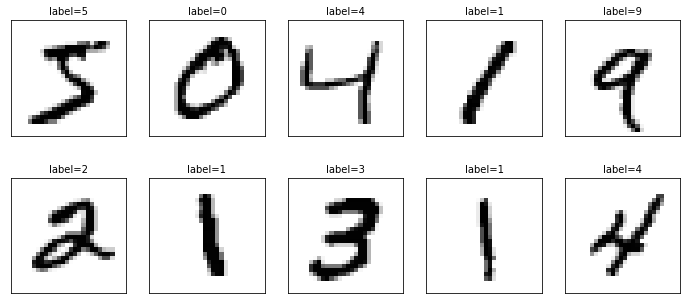

In [7]:
plot_image_labels_prediction(X_train_image,y_train_label,[],0,10) #显示前10张的图像

三.MNIST的数据预处理

1.将image转化为一维向量, 转化过程是图像大小相乘，结果为：28x28 = 784, 以便于能作为神经网络的第一层输入。

In [8]:
X_train = X_train_image.reshape(60000,784).astype('float32') #二维转一维
X_test = X_test_image.reshape(10000,784).astype('float32')

2.对图像数据进行归一化。归一化是必要操作，可以提高准确率。原因是如果没有归一化那么图像的数据值是0-255，不同的图像之间的值差异很大，在训练过程中，小的值很容易被忽略。因此我们需要对数据进行缩放，常见的一种方法是将数据的值压缩到(0,1)区间内，在本例中，直接将数据除以255即可。

In [9]:
X_train_normalize = X_train/255.0 #归一化
X_test_normalize = X_test/255.0

3.对数据标签进行One-hot编码（独热编码），我们都知道数字识别的结果是0-9，但为了满足神经网络的最后一层的10个神经元输出，我们需要将数字转换为二进制的10个0和1的组合，具体可看下面代码例子，第一个为数据的原标签，第二个是One-hot编码后的标签。

In [10]:
y_train_label[:5] #显示前5个图像的对应标签数字

array([5, 0, 4, 1, 9], dtype=uint8)

之后大家可以直接调用keras的utils中的to_categorical函数进行直接数字编码。

In [11]:
y_TrainOneHot = tf.keras.utils.to_categorical(y_train_label) #One-Hot编码
y_TestOneHot = tf.keras.utils.to_categorical(y_test_label)
 
y_TrainOneHot[0:5] #显示前5个数据编码后的结果

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

上图为编码结果，其中1在第几个位置则代表了数字的大小是多少。


四.模型的搭建

1.建立线性堆叠模型Sequential，使用它我们可以搭建出很多复杂的神经网络模型，后面的层就犹如叠面包一样一层一层通过add指令叠加上去就好了，十分方便。

In [12]:
model = tf.keras.models.Sequential() # 调用Sequential模型

2.不断叠加层上去，Dense层是全连接层，指的是神经前后前后两层神经元中两两都有互相连接，而Dropout的层的作用是为了防止过拟合（过拟合概念可自行查询），随机使多少比例的神经元失活，等于是断了之间的连接关系。

In [13]:
#units是该层神经元数量，input_dim是数据输入大小，kernel_initializer=normal指的是用正态分布来初始化神经元的权重和偏差，activation指的是激活函数
model.add(layers.Dense(units=256,input_dim=784,kernel_initializer='normal',activation='relu')) 
model.add(layers.Dropout(0.5)) #使50%的神经元失活
#最终输出是0-9，因此是10个神经元，softmax激活函数可以将输出转化为预测每个数字的概率
model.add(layers.Dense(units=10,kernel_initializer='normal',activation='softmax'))

3.通过summary我们可以查看我们刚才搭建的模型的概要。

In [14]:
print(model.summary()) #显示模型信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


大家可以从上图看到我们刚建立的模型信息，其中Param指的是该层神经元总的参数数量，具体的计算公式是 Param=（上一层神经元数量）x（本层神经元数量）+（本层神经元数量）

比如图中的200960是由（784x256+256）得到的。

五.模型的训练

1.在训练模型之间，我们需要定义一些训练的相关参数，比如优化器、损失函数和评估模型的方式。

In [15]:
#loss这里采用的交叉熵损失，优化器采用的是adam优化器，评估方式为准确率
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2.开始训练，其中validation_split是将原数据集划分一部分为验证集，epoch是训练次数，batch_size是每一批训练的数据量，verbose=2代表显示所有训练过程。

In [16]:
t_start = time.time()
train_history = model.fit(x=X_train_normalize,y=y_TrainOneHot,validation_split=0.2,epochs=10,batch_size=200,verbose=2)
t_end = time.time()
print ("time cost: %5.2f ms" % ((t_end - t_start) * 1000))    #毫秒级时间戳

Epoch 1/10
240/240 - 1s - loss: 0.5511 - accuracy: 0.8417 - val_loss: 0.2320 - val_accuracy: 0.9366
Epoch 2/10
240/240 - 1s - loss: 0.2527 - accuracy: 0.9273 - val_loss: 0.1698 - val_accuracy: 0.9523
Epoch 3/10
240/240 - 1s - loss: 0.1977 - accuracy: 0.9429 - val_loss: 0.1401 - val_accuracy: 0.9594
Epoch 4/10
240/240 - 1s - loss: 0.1659 - accuracy: 0.9522 - val_loss: 0.1219 - val_accuracy: 0.9649
Epoch 5/10
240/240 - 1s - loss: 0.1416 - accuracy: 0.9592 - val_loss: 0.1095 - val_accuracy: 0.9672
Epoch 6/10
240/240 - 1s - loss: 0.1255 - accuracy: 0.9639 - val_loss: 0.0963 - val_accuracy: 0.9710
Epoch 7/10
240/240 - 1s - loss: 0.1141 - accuracy: 0.9659 - val_loss: 0.0936 - val_accuracy: 0.9720
Epoch 8/10
240/240 - 1s - loss: 0.1016 - accuracy: 0.9691 - val_loss: 0.0857 - val_accuracy: 0.9750
Epoch 9/10
240/240 - 1s - loss: 0.0942 - accuracy: 0.9714 - val_loss: 0.0837 - val_accuracy: 0.9756
Epoch 10/10
240/240 - 1s - loss: 0.0906 - accuracy: 0.9724 - val_loss: 0.0785 - val_accuracy: 0.9758

3.我们可以通过train_history查看训练过程，之前的训练步骤的值都保存在这里面。这里共有loss,accuracy,val_loss,val_accuracy四个参数。

In [17]:
train_history.history

{'loss': [0.5511388182640076,
  0.2527346611022949,
  0.19768279790878296,
  0.16589966416358948,
  0.1415978968143463,
  0.12548330426216125,
  0.11414095014333725,
  0.10156828910112381,
  0.09418237954378128,
  0.09064406156539917],
 'accuracy': [0.8416666388511658,
  0.9273124933242798,
  0.9428541660308838,
  0.9521874785423279,
  0.9592499732971191,
  0.9639166593551636,
  0.9659166932106018,
  0.9691458344459534,
  0.9713749885559082,
  0.9723541736602783],
 'val_loss': [0.23201917111873627,
  0.16982021927833557,
  0.140141099691391,
  0.12194325029850006,
  0.10953554511070251,
  0.09634273499250412,
  0.09355369955301285,
  0.08571401983499527,
  0.0836845114827156,
  0.07854077219963074],
 'val_accuracy': [0.9365833401679993,
  0.9523333311080933,
  0.9594166874885559,
  0.9649166464805603,
  0.9672499895095825,
  0.9710000157356262,
  0.972000002861023,
  0.9750000238418579,
  0.9755833148956299,
  0.9758333563804626]}

4.我们还可以定义函数，显示训练的曲线图。

In [18]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train]) #绘制训练数据的执行结果
    plt.plot(train_history.history[validation]) #绘制验证数据的执行结果
    plt.title('Train History') #图标题 
    plt.xlabel('epoch') #x轴标签
    plt.ylabel(train) #y轴标签
    plt.legend(['train','validation'],loc='upper left') #添加左上角图例



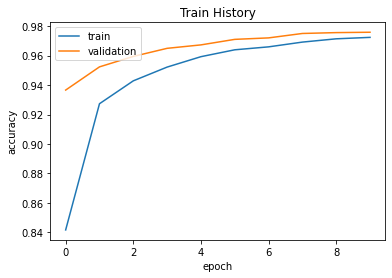

In [19]:
show_train_history(train_history,'accuracy','val_accuracy')

六.模型的测试

1.我们通过evaluate可以使用模型在测试集上进行测试。

In [20]:
scores = model.evaluate(X_test_normalize,y_TestOneHot) 
print('accuracy=',scores[1]) #显示测试准确率

313/313 [==============================] - 1s 2ms/step - loss: 0.0743 - accuracy: 0.9775

2.对模型进行预测，并使用之前我们定义的函数plot_image_labels_prediction，可以方便查看预测结果之间的对应关系。



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


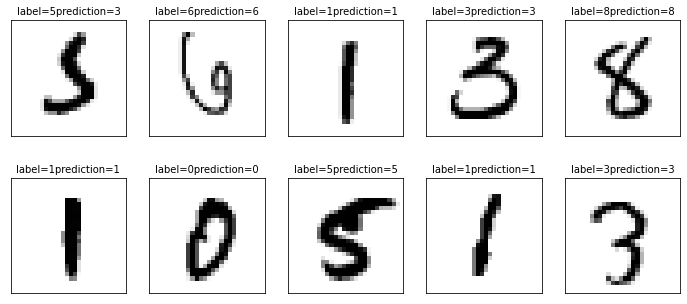

In [21]:
prediction = model.predict_classes(X_test) #结果预测
plot_image_labels_prediction(X_test_image,y_test_label,prediction,idx=340)

3.我们还可以通过pandas中的crosstab调用混淆矩阵，来查看哪些结果最容易混淆，对角线部分，为正确预测的部分，其它部分则是预测错误的部分。

In [22]:
pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,971,0,0,2,1,1,2,1,1,1
1,0,1126,4,0,0,1,2,0,2,0
2,3,0,1011,1,2,0,2,6,7,0
3,0,0,2,992,0,4,0,6,4,2
4,0,0,4,0,962,0,4,2,2,8
5,3,0,0,8,1,869,3,1,5,2
6,7,3,0,1,3,4,934,1,5,0
7,1,6,10,1,0,0,0,1003,1,6
8,4,0,3,7,3,2,2,4,948,1


4.我们还可以通过pandas的DataFrame来查看预测错误数据的位置。

In [23]:
df = pd.DataFrame({'label':y_test_label,'predict':prediction})
print(df[(df.label==5)&(df.predict==3)]) #查看是5预测错成3的数据位置

      label  predict
340       5        3
1393      5        3
2035      5        3
2810      5        3
3902      5        3
5937      5        3
5972      5        3
6598      5        3


或者通过我们先前定义的plot_image_labels_prediction函数，也可以直接查看预测错误的图像。

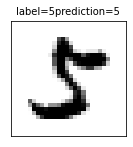

In [24]:
plot_image_labels_prediction(X_test_image,y_test_label,prediction,idx=9482,nums=1)
